# **Step 1: Setup and Data Preparation**

**Install necessary libraries:**

In [18]:
!pip install -q tensorflow matplotlib

**Import Libraries:**

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


**Load the CIFAR-10 Dataset:**

In [20]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (for the softmax model)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print("Data shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Data shapes: (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


**Visualize the Data:**

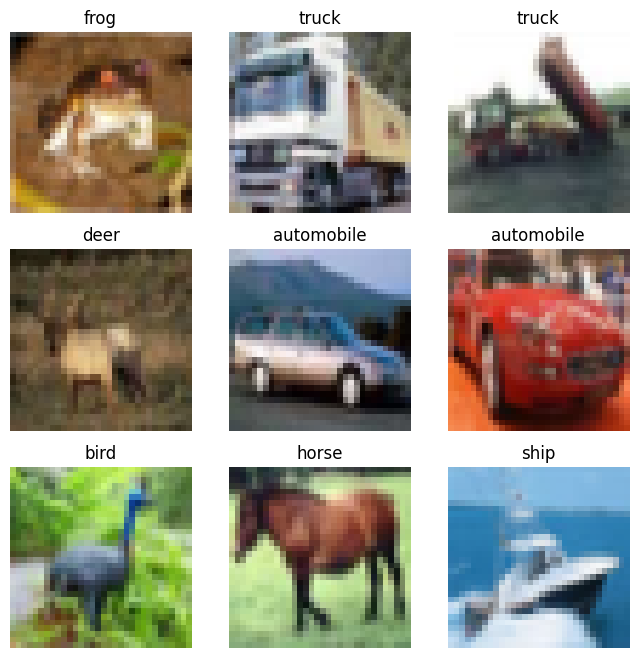

In [21]:
# Function to plot images in a grid
def plot_images(images, labels, classes, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(classes[labels[i][0]])
        ax.axis('off')
    plt.show()

# Class names in CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot some images from the dataset
plot_images(x_train, y_train, class_names)


# **Step 2: Model Definition**


**Define a Base Model:**

We'll create a simple convolutional neural network (CNN) as our base model. This CNN will generate embeddings which can be used for both the contrastive loss and the softmax classification.

In [22]:
def create_base_model():
    model = Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation=None),  # No activation on the final layer
    ])
    return model

# Create the base model
base_model = create_base_model()
base_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)             

**Projection Head for Contrastive Learning:**

We often add a small network on top of the base embeddings specifically for contrastive learning, referred to as a "projection head". This head transforms the embeddings into a space where contrastive loss is more effective.

In [23]:
class ProjectionHead(Layer):
    def __init__(self):
        super(ProjectionHead, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation=None)  # Output size should match the number of classes

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Add the projection head to the base model
projection_head = ProjectionHead()

# **Step 3: Loss Function**

**Supervised Contrastive Loss:**

TensorFlow doesn’t directly provide a supervised contrastive loss function, so we will need to implement it. The essence of this loss is to encourage positive pairs (samples from the same class) to be closer in the embedding space, while pushing negative pairs (samples from different classes) apart.

In [24]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.05, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Normalize the embeddings
        normalized_embeddings = tf.math.l2_normalize(embeddings, axis=-1)
        # Compute the cosine similarity
        similarity_matrix = tf.matmul(normalized_embeddings, normalized_embeddings, transpose_b=True)
        # Scale similarity by the temperature
        similarity_matrix /= self.temperature

        # Create label matrix
        labels = tf.cast(labels, tf.int32)
        label_matrix = tf.equal(labels, tf.transpose(labels))
        label_matrix = tf.cast(label_matrix, tf.float32)

        # Compute the loss
        exp_similarities = tf.exp(similarity_matrix)
        sum_exp_similarities = tf.reduce_sum(exp_similarities * (1 - tf.eye(tf.shape(labels)[0])), axis=-1)

        positive_sum = tf.reduce_sum(exp_similarities * label_matrix, axis=-1)
        contrastive_loss = -tf.math.log(positive_sum / sum_exp_similarities)

        return tf.reduce_mean(contrastive_loss)


**Softmax Cross-Entropy Loss:**

This is the standard loss function used for multi-class classification problems. It’s readily available in TensorFlow, and we can use it directly from tf.keras.losses.

In [25]:
softmax_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


Now that we have defined both loss functions, our next steps will be training the models using these losses:

1. We will first train a model using supervised contrastive loss, using the embeddings and projection head.

2. We will then fine-tune a classifier on top of the trained embeddings using softmax loss.

3. For comparison, we will train another model directly using softmax cross-entropy loss on the original labels.

# **Step 4: Training**
**Part A: Training with Supervised Contrastive Loss**

**1. Training the Model for Contrastive Loss:**

- We will use the base model and the projection head to train with the supervised contrastive loss.

In [26]:
# Create an instance of the base model and projection head
base_model = create_base_model()
projection_head = ProjectionHead()

# Combine base model and projection head
class ContrastiveModel(tf.keras.Model):
    def __init__(self, base_model, projection_head):
        super(ContrastiveModel, self).__init__()
        self.base_model = base_model
        self.projection_head = projection_head

    def call(self, inputs):
        embeddings = self.base_model(inputs)
        projections = self.projection_head(embeddings)
        return projections

contrastive_model = ContrastiveModel(base_model, projection_head)

# Compile the model
contrastive_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=SupervisedContrastiveLoss(temperature=0.07))

# Train the model
contrastive_history = contrastive_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1250/1250 [==============================] - 62s 48ms/step - loss: -7.5389 - val_loss: -8.1284
Epoch 2/10
1250/1250 [==============================] - 54s 43ms/step - loss: -8.4639 - val_loss: -8.6496
Epoch 3/10
1250/1250 [==============================] - 49s 39ms/step - loss: -8.6920 - val_loss: -8.7530
Epoch 4/10
1250/1250 [==============================] - 50s 40ms/step - loss: -8.7962 - val_loss: -8.8417
Epoch 5/10
1250/1250 [==============================] - 50s 40ms/step - loss: -8.8756 - val_loss: -8.8835
Epoch 6/10
1250/1250 [==============================] - 54s 43ms/step - loss: -8.9337 - val_loss: -8.9608
Epoch 7/10
1250/1250 [==============================] - 50s 40ms/step - loss: -8.9382 - val_loss: -8.9559
Epoch 8/10
1250/1250 [==============================] - 52s 42ms/step - loss: -8.9792 - val_loss: -9.0160
Epoch 9/10
1250/1250 [==============================] - 49s 39ms/step - loss: -8.9958 - val_loss: -8.9666
Epoch 10/10
1250/1250 [=======================

**2. Fine-Tuning a Classifier:**

- After training with contrastive loss, we will add a classification head to the trained base model and fine-tune it using softmax loss.

In [27]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
classification_model = Sequential([
    base_model,
    Dense(10, activation='softmax')
])

# Compile the model
classification_model.compile(optimizer=Adam(learning_rate=0.001),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

# Fine-tune the classifier
classifier_history = classification_model.fit(x_train, y_train_categorical, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
1250/1250 [==============================] - 21s 17ms/step - loss: 2.7075 - accuracy: 0.1225 - val_loss: 2.2610 - val_accuracy: 0.1537
Epoch 2/5
1250/1250 [==============================] - 19s 15ms/step - loss: 2.2487 - accuracy: 0.1762 - val_loss: 2.2429 - val_accuracy: 0.1752
Epoch 3/5
1250/1250 [==============================] - 18s 15ms/step - loss: 2.2424 - accuracy: 0.1786 - val_loss: 2.2420 - val_accuracy: 0.1780
Epoch 4/5
1250/1250 [==============================] - 19s 16ms/step - loss: 2.2415 - accuracy: 0.1772 - val_loss: 2.2402 - val_accuracy: 0.1791
Epoch 5/5
1250/1250 [==============================] - 18s 15ms/step - loss: 2.2410 - accuracy: 0.1764 - val_loss: 2.2418 - val_accuracy: 0.1775


# **Part B: Direct Training with Softmax Cross-Entropy**
**1.Training Directly for Classification:**

We will train another instance of the base model directly using softmax cross-entropy for comparison.

In [28]:
# Create and compile the softmax model
softmax_model = create_base_model()
softmax_model.add(Dense(10, activation='softmax'))

softmax_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the softmax model
softmax_history = softmax_model.fit(x_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1250/1250 [==============================] - 54s 43ms/step - loss: 1.6014 - accuracy: 0.4128 - val_loss: 1.3047 - val_accuracy: 0.5326
Epoch 2/10
1250/1250 [==============================] - 51s 41ms/step - loss: 1.2349 - accuracy: 0.5567 - val_loss: 1.1373 - val_accuracy: 0.5993
Epoch 3/10
1250/1250 [==============================] - 51s 40ms/step - loss: 1.0826 - accuracy: 0.6155 - val_loss: 1.0375 - val_accuracy: 0.6367
Epoch 4/10
1250/1250 [==============================] - 56s 44ms/step - loss: 0.9886 - accuracy: 0.6492 - val_loss: 0.9898 - val_accuracy: 0.6517
Epoch 5/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.9069 - accuracy: 0.6813 - val_loss: 0.9460 - val_accuracy: 0.6619
Epoch 6/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.8452 - accuracy: 0.7017 - val_loss: 0.9514 - val_accuracy: 0.6692
Epoch 7/10
1250/1250 [==============================] - 50s 40ms/step - loss: 0.7972 - accuracy: 0.7194 - val_loss: 0.9578 -

# **Evaluation and Visualization**

**Part A: Evaluating the Models**

**1. Evaluate Both Models on the Test Set:**

- Measure the accuracy of both the fine-tuned classification model and the direct softmax model.

In [29]:
# Evaluate the fine-tuned classifier
classifier_loss, classifier_accuracy = classification_model.evaluate(x_test, y_test_categorical)
print(f"Fine-tuned Classifier Accuracy: {classifier_accuracy*100:.2f}%")

# Evaluate the softmax model
softmax_loss, softmax_accuracy = softmax_model.evaluate(x_test, y_test_categorical)
print(f"Softmax Classifier Accuracy: {softmax_accuracy*100:.2f}%")


313/313 [==============================] - 5s 15ms/step - loss: 2.2398 - accuracy: 0.1727
Fine-tuned Classifier Accuracy: 17.27%
313/313 [==============================] - 4s 14ms/step - loss: 0.9243 - accuracy: 0.6941
Softmax Classifier Accuracy: 69.41%


# **Part B: Visualizing Embeddings**
**1. Visualize the Embeddings:**
- To understand how embeddings cluster different classes, we will visualize the embeddings generated by the base model before the projection head. This helps in understanding the effectiveness of contrastive learning.

32/32 [==============================] - 1s 34ms/step


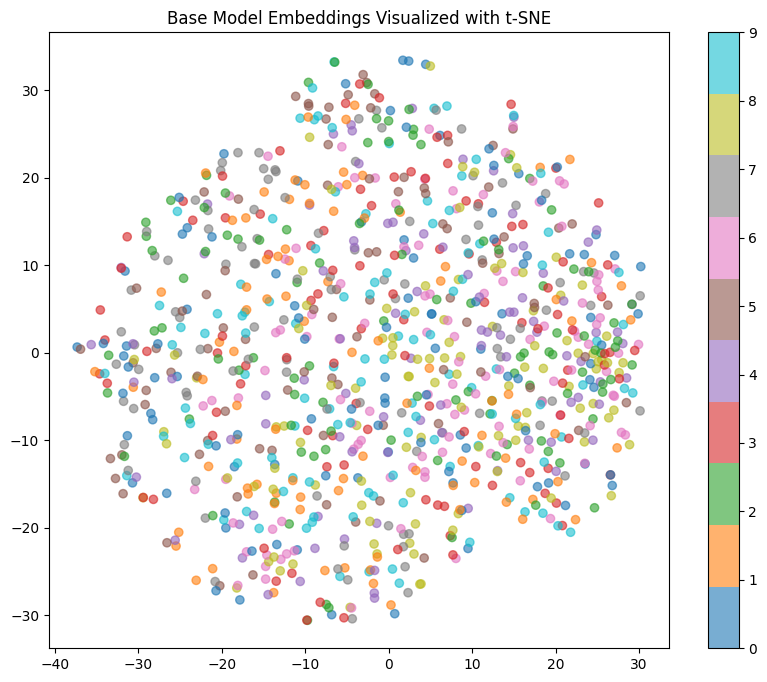

In [30]:
# Function to extract embeddings from the base model
def get_embeddings(model, data):
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)  # -2 to get the last embedding layer
    return intermediate_model.predict(data)

# Extract embeddings for a subset of the test data
embeddings = get_embeddings(base_model, x_test[:1000])
labels = y_test[:1000]

# Reduce dimensions for visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_reduced = tsne.fit_transform(embeddings)

# Function to plot embeddings
def plot_embeddings(embeddings, labels, title="Embeddings"):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.show()

# Plot the embeddings
plot_embeddings(embeddings_reduced, labels, "Base Model Embeddings Visualized with t-SNE")

By comparing the accuracy and visualizing the embeddings, you can see the effect of each training approach. Contrastive learning should ideally result in clearer clusters of embeddings compared to direct training with softmax, indicating better generalization.

**The different colors in the plot represent different classes of the CIFAR-10 dataset. Here is what each color indicates:**


0 (Red): Airplane

1 (Orange): Automobile

2 (Yellow): Bird

3 (Green): Cat

4 (Light Blue): Deer

5 (Blue): Dog

6 (Purple): Frog

7 (Pink): Horse

8 (Grey): Ship

9 (Olive): Truck

Each dot represents an embedding of an image, and its color corresponds to the actual class of that image. This visualization helps to see how well the embeddings from different classes are clustered or spread out, indicating the effectiveness of the model in creating distinguishable features for each class.

## **Summary and Insights**
**1. Model Performance:**

You should have the accuracy metrics for both the fine-tuned classifier that was initially trained with supervised contrastive loss and the model trained directly with softmax cross-entropy. Typically, the model trained with contrastive loss might show better or comparable generalization, especially if the dataset is complex or involves subtle intra-class variations.

**2. Embeddings Visualization:**

The t-SNE visualization of the embeddings from the base model trained with contrastive loss should ideally show more distinct clustering of classes compared to the direct softmax-trained model. This demonstrates that contrastive learning can lead to embeddings that are more separable in the feature space, which is beneficial for classification tasks, especially in more complex or less clearly defined datasets.